## Answering Business Questions using SQL
### Introduction

The purpose of this project is to practice SQL. 
We are going to use Chinook database to answer some business questions.

<img src="img/chinook-schema.svg" alt="Chinook DB schema" width="500">
<center>Chinook DB Schema</center>

### Creating Helper Functions

In [1]:
# imports
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
db = 'chinook.db'

def run_query(q):   # returns a dataframe
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):  # runs queries that don't return tables
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
        SELECT
            name, 
            type
        FROM sqlite_master
        WHERE type IN ("table", "view")'''
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


###  Selecting Albums to Purchase

The task is to select the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce: ![New artists list](img/new_artists.png)
We are interested in finding out which genres sell the best in the USA.

In [4]:
albums_to_purchase = '''
        WITH tracks_usa AS
            (SELECT 
                il.track_id,
                SUM(il.quantity) sold
            FROM invoice_line il
            INNER JOIN invoice i ON il.invoice_id = i.invoice_id
            WHERE i.billing_country = "USA"
            GROUP BY 1),
            tracks_genre AS
            (SELECT
                g.name,
                t.track_id
                FROM genre g
            INNER JOIN track t ON t.genre_id = g.genre_id)
        SELECT 
            tg.name genre,
            SUM(tu.sold) tracks_number,
            CAST(COUNT(tu.track_id) AS FLOAT) / (SELECT COUNT(*) from tracks_usa) * 100 percentage_sold
        FROM tracks_genre tg
        INNER JOIN tracks_usa tu ON tu.track_id = tg.track_id
        GROUP BY 1
        ORDER BY 2 DESC
        LIMIT 10;
        '''

run_query(albums_to_purchase)

,genre,tracks_number,percentage_sold
0,Rock,561,52.911392
1,Alternative & Punk,130,12.025316
2,Metal,124,11.012658
3,R&B/Soul,53,4.556962
4,Blues,36,3.544304
5,Alternative,35,2.911392
6,Latin,22,2.784810
7,Pop,22,2.405063
8,Hip Hop/Rap,20,2.405063
9,Jazz,14,1.772152


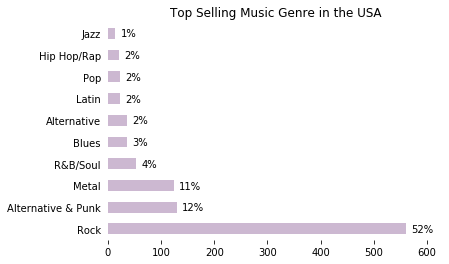

In [5]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_number"].plot.barh(
    title="Top Selling Music Genre in the USA",
    xlim=(0, 630), 
    color='#CCB8D1')

plt.ylabel("")
plt.tick_params(left=False)
plt.box(False)

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_number"]
    label = (genre_sales_usa.loc[label, "percentage_sold"]).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i-0.15))

plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:
- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres make up only 17% of the total sales, so we should be on the lookout for artists and the albums from the 'rock' genre, which accounts for 52% of sales.

### Analysing Employee Sales Performance

The task is to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [6]:
employee_sales_performance = '''
WITH sales_by_customer AS (
    SELECT 
        c.customer_id,
        c.support_rep_id,
        SUM(i.total) sales
    FROM customer c
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY 1)

SELECT 
    e.first_name || " " || e.last_name employee,
    DATE(e.hire_date) hire_date,
    SUM(sbc.sales) sales
FROM employee e
INNER JOIN sales_by_customer sbc ON e.employee_id = sbc.support_rep_id
GROUP BY 1
ORDER BY 2 DESC;

'''

run_query(employee_sales_performance)

,employee,hire_date,sales
0,Steve Johnson,2017-10-17,1393.92
1,Margaret Park,2017-05-03,1584.00
2,Jane Peacock,2017-04-01,1731.51


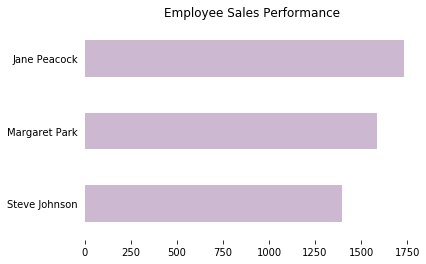

In [7]:
employee_sales = run_query(employee_sales_performance)
employee_sales.set_index("employee", inplace=True, drop=True)
employee_sales.plot.barh(
    title = "Employee Sales Performance", 
    legend = False,
    color="#CCB8D1")
plt.ylabel("")
plt.tick_params(left=False)
plt.box(False)

plt.show()

While there is a 20% difference between the top employee (Jane) and the bottom employee (Steve), this difference corresponds with the difference in their hiring date.

### Analyzing Sales by Country


In [8]:
"""
a query that selects the countries and its corresponding
number of customers, and combines the countries with one customer
only into one group called "Other".
"""

sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


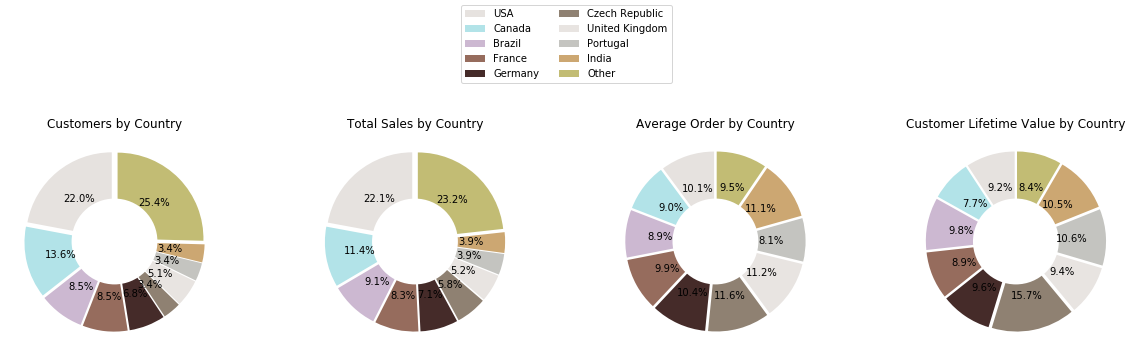

In [9]:
sales = run_query(sales_by_country)
values = ["customers", "total_sales", "average_order", "customer_lifetime_value"]

#colors
colors = ['#E6E2DF', '#B2E3E8', '#CCB8D1', '#966C5D', '#452B29', '#8F8172', '#E8E4E1', '#C4C4C0', '#CCA772', '#C2BC74']
#explosion
explode = (0.05,0.05,0.05,0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, value in enumerate(values, start=1):
    ax = fig.add_subplot(2, 4, i)
    ax.pie(sales[value], explode=explode, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.set_title("{} by Country".format(value.title().replace("_", " ")))
    centre_circle = plt.Circle((0,0),0.50,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
# ax2 = fig.add_subplot(2,4,2)
# ax2.legend(sales["country"], positions=[1,1])

labels = sales["country"]
# fig.legend( labels, loc='lower center')

fig.legend(labels, loc = 'upper center', ncol=2)
plt.show()


The USA is the leader country in the number of customers and total sales, as the plot shows. There is not much difference between countries when analyzing the average order chart, as for lifetime value of customers Check Republic leads with almost 16%.